# Transfer Learning with TensorFlow Part 3: Scaling up (🍔👁 Food Vision mini)
We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

See full course materials on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning




Creating helper functions

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them.

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 


--2022-05-15 13:17:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-05-15 13:17:59 (38.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir


## 101 Food Classes: working with less data
Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the image_data_modification notebook - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"



--2022-05-15 13:18:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.197.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   231MB/s    in 6.3s    

2022-05-15 13:18:16 (248 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/escargots'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/macaroni_and_cheese'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hot_dog'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lasagna'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pulled_pork_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spaghetti_bolognese'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spaghetti_carbonara'.
There are 0 directorie

In [ ]:
# setup data inputs
import tensorflow as tf 
img_shape = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                                label_mode = "categorical",
                                                                                image_size=img_shape)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                label_mode="categorical",
                                                                image_size=img_shape,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes
Here are the steps we're going to take:

* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)


In [ ]:
# create model check point callback only save best validation accuracy
checkpoint_path = "model_check_point_101_food_classes_10_percent"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor="val_accuracy",
                                                         save_weights_only=True,
                                                         save_best_only=True)

In [ ]:
# create data augmentation layer to incorprorate it right into our model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Sequential

data_augmantation = Sequential([
   preprocessing.RandomFlip(mode="horizontal"),
   preprocessing.RandomRotation(0.2),
   preprocessing.RandomHeight(0.2),
   preprocessing.RandomWidth(0.2),
   preprocessing.RandomZoom(0.2),
   # preprocessing.Rescaling(1/255.)  Rescaling data in 0 and 1 it is requred on model like ResNet50
],name="data_augmantation")

In [ ]:
# Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)

# create base model 
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
# creat input layer
inputs = layers.Input(shape=(224, 224, 3),name="input_layers")
# data augmantation
x = data_augmantation(inputs,training=True)
# pass through the base model
x = base_model(x,training=False)
# pooled out ou model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
# output layer create
outputs = layers.Dense(len(train_data_all_10_percent.class_names),activation="softmax",name="outputs_layers")(x)

# pass through the tensorflow model and create model 1
model_1 = tf.keras.Model(inputs,outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
# compile the model
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
model_1_history = model_1.fit(train_data_all_10_percent,
                              epochs=5,
                              validation_data=test_data,
                              validation_steps=int(0.15 * len(test_data)),
                              callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 108s 387ms/step - loss: 3.4786 - accuracy: 0.2446 - val_loss: 2.7734 - val_accuracy: 0.3755
Epoch 2/5
237/237 [==============================] - 68s 285ms/step - loss: 2.3437 - accuracy: 0.4595 - val_loss: 2.4234 - val_accuracy: 0.4166
Epoch 3/5
237/237 [==============================] - 59s 245ms/step - loss: 1.9803 - accuracy: 0.5319 - val_loss: 2.2407 - val_accuracy: 0.4486
Epoch 4/5
237/237 [==============================] - 56s 236ms/step - loss: 1.7529 - accuracy: 0.5793 - val_loss: 2.1293 - val_accuracy: 0.4719
Epoch 5/5
237/237 [==============================] - 49s 206ms/step - loss: 1.6100 - accuracy: 0.6055 - val_loss: 2.1166 - val_accuracy: 0.4711


In [ ]:
# evaluate our model whole data set
feature_extraction_result = model_1.evaluate(test_data)
feature_extraction_result

790/790 [==============================] - 100s 127ms/step - loss: 1.9146 - accuracy: 0.5158


[1.9145702123641968, 0.5157623887062073]

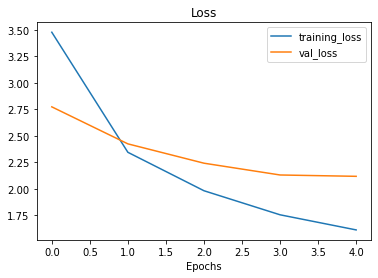

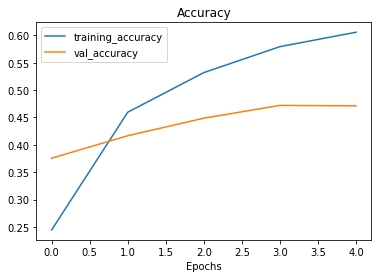

In [ ]:
# let's see loss curves
plot_loss_curves(model_1_history)

> 🤔 **Question:** What do these curves suggest? Hint: ideally, the two curves should be very similar to each other, if not it may suggest that our model is overfitting (performing too well on the training data and not generalizing to unseen data).

## Fine-Tuning

In [ ]:
# Unfrozen all layer in base model
base_model.trainable = True
# Refreez layer but last 5 not freez
for layer in base_model.layers[:-5]:
    layer.trainable = False


In [ ]:
# recompile the model and all ways folow more you depper fine-tuning lower learning rate is good practice.
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# what layer are trainable
for layer in model_1.layers:
    print(layer.name,layer.trainable)

input_layers True
data_augmantation True
efficientnetb0 True
global_average_pooling_2D True
outputs_layers True


In [ ]:
# which layer are trainable in base_model
for layer_num,layer in enumerate(model_1.layers[2].layers):
    print(layer_num,layer.name,layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
# Fit the model Fine tuning result see
fine_tuning_epoch = len(model_1_history.epoch) + 5
fine_tuning_history_1 = model_1.fit(train_data_all_10_percent,
                                    epochs=fine_tuning_epoch,
                                    validation_data=test_data,
                                    validation_steps= int(0.15 * len(test_data)),
                                    initial_epoch=model_1_history.epoch[-1])

Epoch 5/10
237/237 [==============================] - 53s 195ms/step - loss: 1.3627 - accuracy: 0.6556 - val_loss: 2.0321 - val_accuracy: 0.4801
Epoch 6/10
237/237 [==============================] - 40s 169ms/step - loss: 1.2383 - accuracy: 0.6788 - val_loss: 2.0158 - val_accuracy: 0.4873
Epoch 7/10
237/237 [==============================] - 39s 165ms/step - loss: 1.1544 - accuracy: 0.6916 - val_loss: 2.0414 - val_accuracy: 0.4841
Epoch 8/10
237/237 [==============================] - 37s 154ms/step - loss: 1.0816 - accuracy: 0.7114 - val_loss: 2.0885 - val_accuracy: 0.4669
Epoch 9/10
237/237 [==============================] - 36s 148ms/step - loss: 1.0246 - accuracy: 0.7251 - val_loss: 2.0561 - val_accuracy: 0.4833
Epoch 10/10
237/237 [==============================] - 36s 152ms/step - loss: 0.9686 - accuracy: 0.7447 - val_loss: 2.0040 - val_accuracy: 0.4907


In [ ]:
# Evaluate whole data set in fine-tune model
fine_tuning_result = model_1.evaluate(test_data)
fine_tuning_result

790/790 [==============================] - 79s 100ms/step - loss: 1.7888 - accuracy: 0.5427


[1.7887848615646362, 0.5426930785179138]

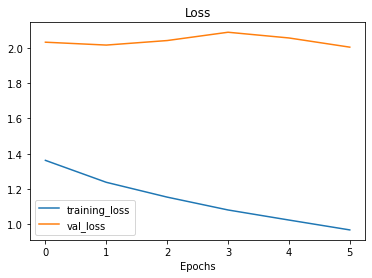

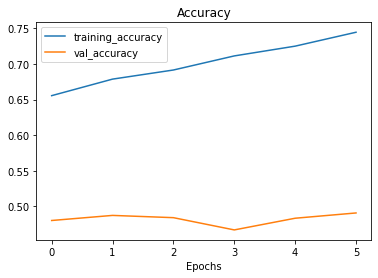

In [ ]:
plot_loss_curves(fine_tuning_history_1)

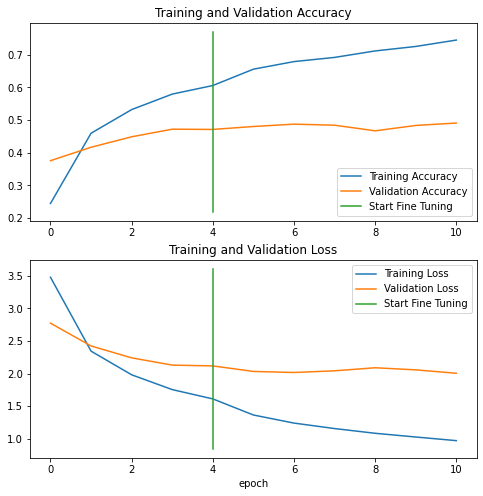

In [ ]:
# compare history feature extraction with fine-tuning model which model performance best (restore compare function halper_function.py)
from helper_functions  import compare_historys
compare_historys(original_history=model_1_history,new_history=fine_tuning_history_1,initial_epochs=5)


## Save And Load model
To use our model extranal application, we'll need save it and export it.

In [ ]:
model_1.save("drive/MyDrive/tensorflow_course/model_101_food_classes_fine_tuning")

INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow_course/model_101_food_classes_fine_tuning/assets


In [ ]:
# load our model and evaluate 
load_model_1 = tf.keras.models.load_model("drive/MyDrive/tensorflow_course/model_101_food_classes_fine_tuning")

In [ ]:
load_model_1.evaluate(test_data)

790/790 [==============================] - 76s 94ms/step - loss: 1.7952 - accuracy: 0.5429


[1.795164942741394, 0.5429307222366333]

In [ ]:
# see note book save model evaluate result
fine_tuning_result

[1.7887848615646362, 0.5426930785179138]


## Evaluating the performance of the big dog model across all different classes
Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong.

In [ ]:
# Download pretrained model (one that was prepared earlier, so all predictions are similar)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-05-15 13:34:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  64.8MB/s    in 0.7s    

2022-05-15 13:34:27 (64.8 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
# unzip down model
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
# load the model and evaluate
downloaded_model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
# evalutate downloaded model
downloaded_model_result = downloaded_model.evaluate(test_data)
downloaded_model_result

790/790 [==============================] - 59s 73ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

## Model prediction with our training model



In [ ]:
# make prediction our model 
preds_probs = downloaded_model.predict(test_data,verbose=1) # set verbosity to see how long is left
preds_probs

790/790 [==============================] - 61s 76ms/step


array([[5.95419519e-02, 3.57420822e-06, 4.13769744e-02, ...,
        1.41386802e-09, 8.35308310e-05, 3.08975112e-03],
       [9.64016795e-01, 1.37532719e-09, 8.47805757e-04, ...,
        5.42869457e-05, 7.83628110e-12, 9.84662130e-10],
       [9.59258795e-01, 3.25336223e-05, 1.48669351e-03, ...,
        7.18910712e-07, 5.43971169e-07, 4.02757760e-05],
       ...,
       [1.51387094e-05, 4.09729051e-04, 8.02503064e-10, ...,
        2.17428933e-05, 1.07972337e-05, 5.37899673e-01],
       [5.93182212e-03, 4.92367381e-03, 9.98234656e-03, ...,
        1.19895354e-04, 1.68903825e-05, 4.52181026e-02],
       [3.13634649e-02, 7.50526646e-03, 4.29749402e-04, ...,
        5.03465941e-04, 5.20561434e-06, 6.90628111e-01]], dtype=float32)

In [ ]:
# see len of test data
len(test_data)

790

In [ ]:
# how predication are there?
len(preds_probs)

25250

In [ ]:
# what's the shape our prediction 
preds_probs.shape

(25250, 101)

In [ ]:
# let's see what the 10 prediction look like
preds_probs[:10]

array([[5.9541952e-02, 3.5742082e-06, 4.1376974e-02, ..., 1.4138680e-09,
        8.3530831e-05, 3.0897511e-03],
       [9.6401680e-01, 1.3753272e-09, 8.4780576e-04, ..., 5.4286946e-05,
        7.8362811e-12, 9.8466213e-10],
       [9.5925879e-01, 3.2533622e-05, 1.4866935e-03, ..., 7.1891071e-07,
        5.4397117e-07, 4.0275776e-05],
       ...,
       [4.7313267e-01, 1.2931186e-07, 1.4805621e-03, ..., 5.9750048e-04,
        6.6968976e-05, 2.3469211e-05],
       [4.4571947e-02, 4.7265419e-07, 1.2258486e-01, ..., 6.3498483e-06,
        7.5318626e-06, 3.6778681e-03],
       [7.2438961e-01, 1.9249808e-09, 5.2310945e-05, ..., 1.2291385e-03,
        1.5792746e-09, 9.6395852e-05]], dtype=float32)

In [ ]:

# We get one prediction probability per class (in our case there's 101 predction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 look like: \n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 look like: 
 [5.95419519e-02 3.57420822e-06 4.13769744e-02 1.06605547e-09
 8.16142798e-09 8.66396554e-09 8.09271114e-07 8.56526640e-07
 1.98590151e-05 8.09776168e-07 3.17277427e-09 9.86738314e-07
 2.85322167e-04 7.80493392e-10 7.42300879e-04 3.89163397e-05
 6.47404340e-06 2.49773279e-06 3.78911318e-05 2.06783056e-07
 1.55384496e-05 8.15069370e-07 2.62305412e-06 2.00106655e-07
 8.38272967e-07 5.42159842e-06 3.73909279e-06 1.31505820e-08
 2.77614314e-03 2.80519198e-05 6.85624113e-10 2.55748309e-05
 1.66888960e-04 7.64069974e-10 4.04528371e-04 1.31506335e-08
 1.79573772e-06 1.44482158e-06 2.30628997e-02 8.24667779e-07
 8.53657696e-07 1.71386114e-06 7.05252342e-06 1.84021669e-08
 2.85532963e-07 7.94833795e-06 2.06815525e-06 1.85251338e-07
 3.36196422e-08 3.15225538e-04 1.04109122e-05 8.54483574e-07
 8.47418606e-01 1.05554345e-05 4.40945854e-07 3.74041447e-05
 3.53061914e-05 3.24890389e-05 6.73146787e-

In [ ]:
# see model frist predict which class name
test_data.class_names[52]

'gyoza'

In [ ]:
# Get the pred classes of each label
preds_classes = preds_probs.argmax(axis=1)
preds_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [ ]:
# len of preds classes
len(preds_classes)

25250

Now we've got a predictions array of all of our model's predictions, to evaluate them, we need to compare them to the original test dataset labels.



In [ ]:
# To get our test labels we need to unravel our test_data BatchDataset

y_label = []

for image , label in test_data.unbatch():
    y_label.append(label.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1, .... 0, 0], we want the index value where the "1" occurs

# look at frist 10 pred classes
y_label[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# How many label are there
len(y_label)

25250

In [ ]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [ ]:
len(test_data)

790

### Evaluating our model's predictions

One way to check that our model's predictions array (pred classes) is in the same order as our test labels array (y_labels) is to find the accuracy score.

In [ ]:
downloaded_model_result

[1.8027206659317017, 0.6077623963356018]

In [ ]:
# Let's try scikit-learn's accuracy score function and see what it comes up with

from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_true=y_label,
                                  y_pred=preds_classes)
sklearn_accuracy

0.6077623762376237

In [ ]:
# check to is close to evaluate predictions model
import numpy as np
np.isclose(downloaded_model_result[1],sklearn_accuracy)

True

## Let's get visualize , making a confusion matrix

In [ ]:
from helper_functions import confusion_matrix

In [ ]:
# Get it class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
# helper_function confusion matrix function some changes 
# We need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ## Changed (plot x-label vertically) ## 
  plt.xticks(rotation=70,fontsize=text_size)
  plt.yticks(fontsize=text_size)
  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


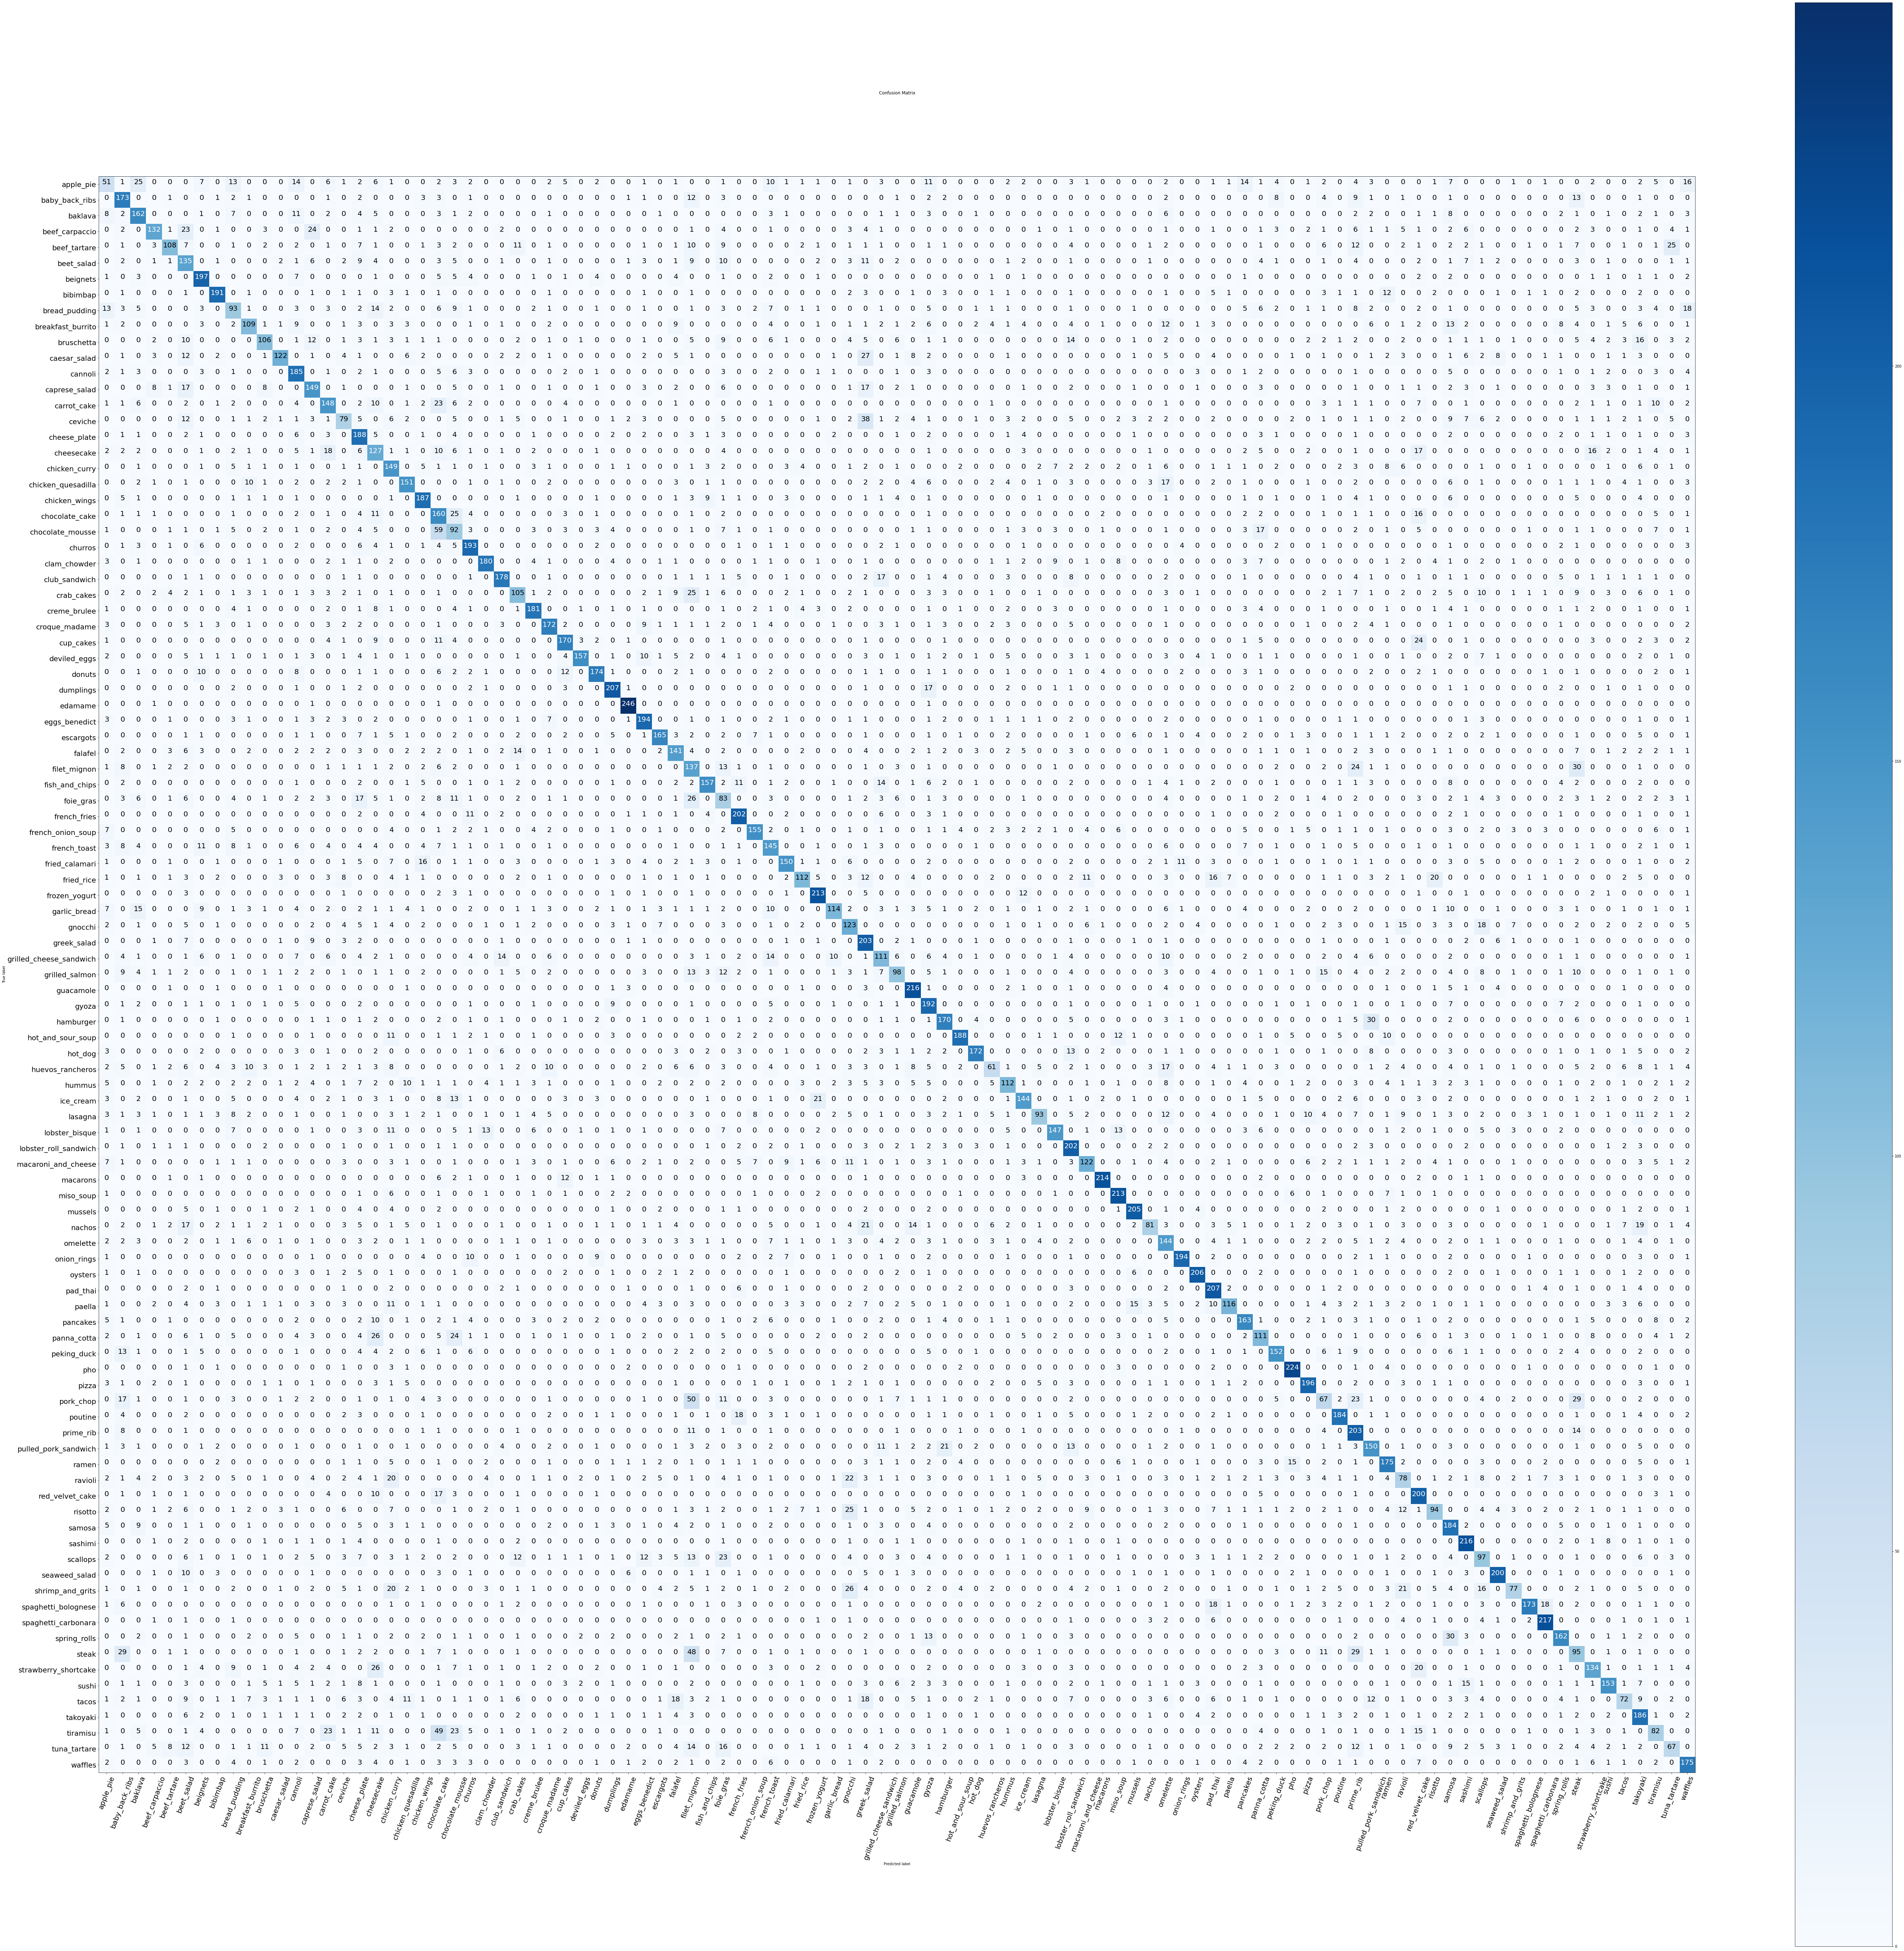

In [ ]:
make_confusion_matrix(y_true=y_label,
                      y_pred=preds_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20,
                      savefig=True)

## Let's keep the evaluation train going, time for a classification report
Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall and F1) called classification_report, let's try it out.



In [ ]:
from sklearn.metrics import  classification_report
print(classification_report(y_true=y_label,
                            y_pred=preds_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

he numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand.

How about we create a visualization to get a better understanding?

In [ ]:
# get a dictionary of the classification report
classification_dict = classification_report(y_true=y_label,
                                            y_pred=preds_classes,
                                            output_dict=True)

In [ ]:
classification_dict

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

In [ ]:
# let's plot f1 score
class_names[98]

'tiramisu'

In [ ]:
classification_dict["98"]["f1-score"]

0.3858823529411765

In [ ]:
# create empy dictionary
class_f1_score = {}

for k,v in classification_dict.items():
    if k == "accuracy":
        break
    else :
        class_f1_score[class_names[int(k)]] = v["f1-score"]

In [ ]:
class_f1_score

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [ ]:
# Turn dictionary into dataframe
import pandas as pd
f1_score = pd.DataFrame({"class_names":list(class_f1_score.keys()),
                         "f1-score":list(class_f1_score.values())}).sort_values("f1-score",ascending=False)

In [ ]:
f1_score

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
56     huevos_rancheros  0.339833
22     chocolate_mousse  0.329159
77            pork_chop  0.308756
39            foie_gras  0.297491
0             apple_pie  0.240566

[101 rows x 2 columns]

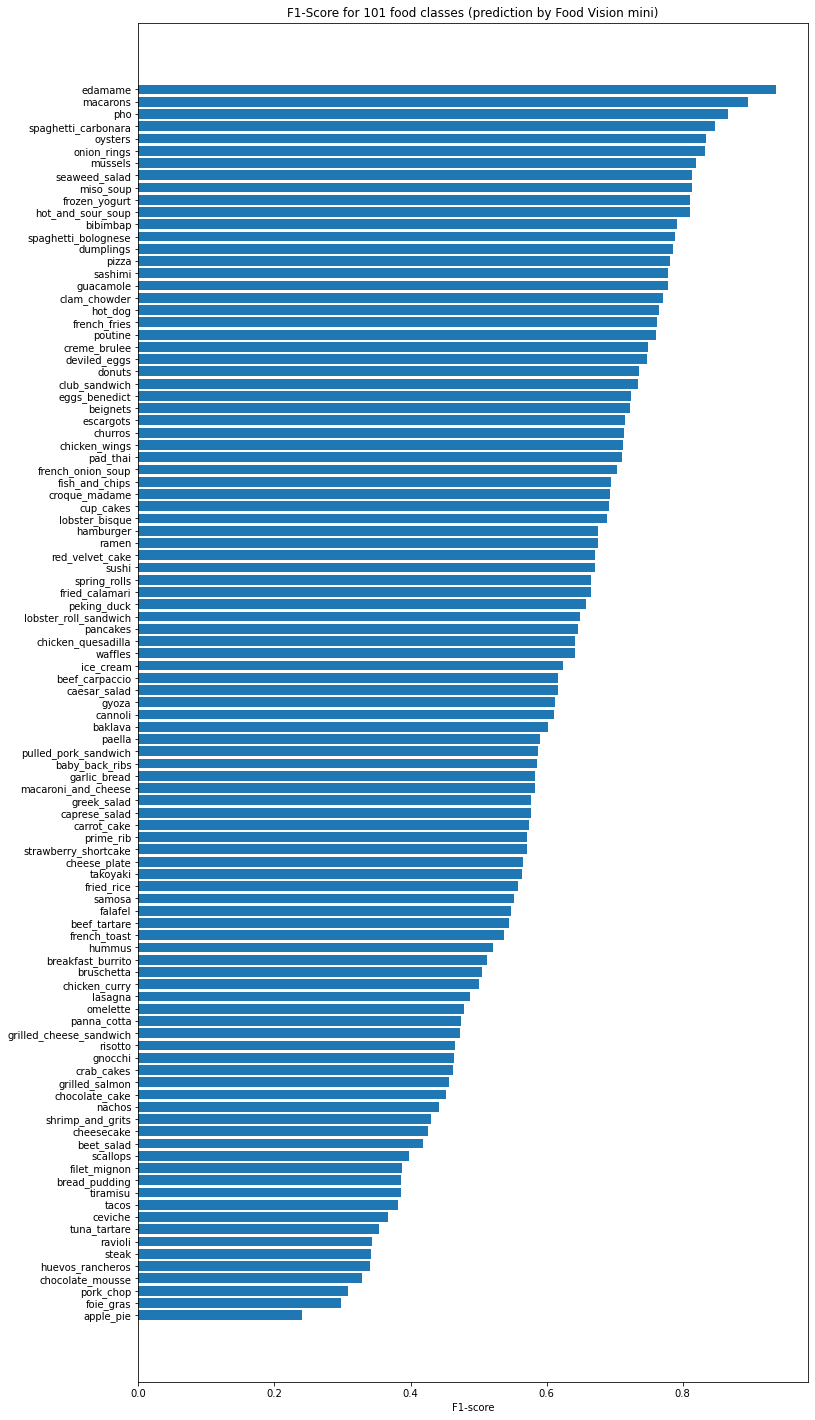

In [ ]:
import matplotlib.pyplot as plt

fig , ax = plt.subplots(figsize=(12,25))
score = ax.barh(range(len(f1_score)),f1_score["f1-score"].values)
ax.set_yticks(range(len(f1_score)))
ax.set_yticklabels(f1_score["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-Score for 101 food classes (prediction by Food Vision mini)")
ax.invert_yaxis(); # reverse the order of our plot


# Challenge: add values to the end of each bar of what the actual f1-score is 
# (hint: use the "autolabel" function from here: https://matplotlib.org/2.0.2/examples/api/barchart_demo.html)



> **🛠 Exercise:** Try visualizing some of the most poorly predicted classes (e.g. apple_pie, pork_chip), do you notice any trends among them? Why might our model be having trouble with them?

## Visualizing predictions on test images

Now, this is the real test, how does our model go on food images not even in our test dataset (images of our own, we'll see this later on).

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images, specifically it will need to:

1. Read in a target image filepath using tf.io.read_file()
2. Turn the image into a Tensor using tf.io.decode_image()
3. Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
4. Scale the image to get all of the pixel values between 0 & 1 (if necessary)


In [ ]:
# created a function to load image prepare 
def load_and_prep_image(filename,img_size=224,scale=True):
    """
    Reads the an image from filename, turn into a tensor and reshape 
    specify to (img_size,img_size,colorchanel=3).

    Args:
      filename (str): path to target image
      img_size (int): hight/width dimension target image size
      scale (bool): scale pixel value 0-255 to 0-1 or not

    return:
       Image tensor fo shape (img_size,img_size,3)
    """

    # read the file 
    img = tf.io.read_file(filename)
    # Turn the image into a tensor
    img = tf.io.decode_image(img,channels=3) 
    # Resize the image tensor to be the same size as the images our model trained on 
    img = tf.image.resize(img,[img_size,img_size])
    # scale the image to get all the pixel values between 0&1(if necessary)
    if scale:
        return img/255.
    else:
        return img # not scale this whe you use efficientNetB0 type pretrainaid model in tensorflow (already have this process)


Now we've got a function to load and prepare target images, let's now write some code to visualize images, their target label and our model's predictions.

Specifically, we'll write some code to:

1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image(s) along with the model's predictions, prediction probability and truth label


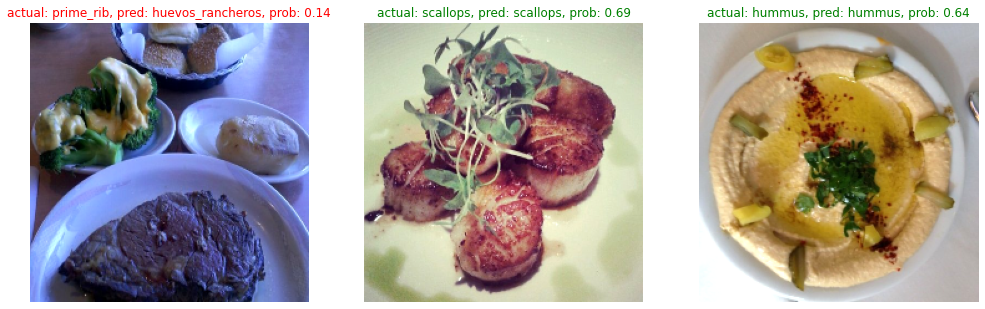

In [ ]:
# Make preds on a series of random images

import os
import random

plt.figure(figsize=(17,10))

for i in range(3):
    # choose random image (s) choose random class names.
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + "/" + class_name))
    target_image = test_dir + class_name + "/" + filename
    # print(class_name)
    # print(filename)
    # print(target_image)

    # Load the image and make predictions
    img = load_and_prep_image(target_image, scale=False)
    img_expanded = tf.expand_dims(img, axis=0)
    # print(img_expanded.shape)
    pred_prob = model_1.predict(img_expanded) # get prediction probabilities array
    pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index and match it class_names list
    # print(pred_prob)
    # print(pred_class)

      # Plot the image(s)
    plt.subplot(1, 3, i+1)
   # print(img)
    plt.imshow(img/225.)
    if class_name == pred_class: # if predicted class matches truth class, make text green
      title_color = "g"
    else:
      title_color = "r"
    plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False);


## Finding the most wrong predictions
To find out where our model is most wrong, let's write some code to find out the following:

1. Get all of the image file paths in the test dataset using list_files() method
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names, ground truth class names.
3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top).
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.


In [ ]:
# 1. Get the all test_data file_directory
test_data_list = []
for item in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                       shuffle=False):
    test_data_list.append(item.numpy())

test_data_list

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/116705.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1167170.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1174330.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1180600.jpg',
 b'/content/101_food_classes_10_percen

In [ ]:
# 2. Create a pandas DataFrame of the image filepaths, ground truth labels, 
# predicted classes (from our model), max prediction probabilities, prediction class names, ground truth class names.
import pandas as pd
pred_frame = pd.DataFrame({"file_path":test_data_list,
                           "y_true":y_label,
                           "y_pred":preds_classes,
                           "pred_conf":preds_probs.max(axis=1),
                           "truth_class_name": [class_names[i] for i in  y_label],
                           "pred_class_name":[class_names[i] for i in preds_classes]})
pred_frame

file_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      52   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0      80   
4      b'/content/101_food_classes_10_percent/test/ap...       0      79   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf truth_class_name       pred_class_name  
0       0.847419        apple_pie                 gyoza  
1       0.964017        apple_pie             apple_pie  
2       0.959259        apple_pie             apple_pie  
3       0.658607        apple_pie  pulled_pork_sandwich  
4       0.367900        apple_pie             prime_rib  
...          ...              ...                   ...  
25245   0.972823          waffles               waffles  
25246   0.878027          waffles          cheese_plate  
25247   0.537900          waffles               waffles  
25248   0.501950          waffles  strawberry_shortcake  
25249   0.690628          waffles               waffles  

[25250 rows x 6 columns]

In [ ]:
len(y_label),len(preds_classes),len(preds_probs)

(25250, 25250, 25250)

In [ ]:
# 3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediction).
pred_frame["pred_correct"] = pred_frame["y_true"] == pred_frame["y_pred"]
pred_frame

file_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      52   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0      80   
4      b'/content/101_food_classes_10_percent/test/ap...       0      79   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf truth_class_name       pred_class_name  pred_correct  
0       0.847419        apple_pie                 gyoza         False  
1       0.964017        apple_pie             apple_pie          True  
2       0.959259        apple_pie             apple_pie          True  
3       0.658607        apple_pie  pulled_pork_sandwich         False  
4       0.367900        apple_pie             prime_rib         False  
...          ...              ...                   ...           ...  
25245   0.972823          waffles               waffles          True  
25246   0.878027          waffles          cheese_plate         False  
25247   0.537900          waffles               waffles          True  
25248   0.501950          waffles  strawberry_shortcake         False  
25249   0.690628          waffles               waffles          True  

[25250 rows x 7 columns]

In [ ]:
# 4. Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top).
top_100_wrong = pred_frame[pred_frame["pred_correct"] == False].sort_values("pred_conf",ascending=False)[:100]
top_100_wrong[:20]

file_path  y_true  y_pred  \
21810  b'/content/101_food_classes_10_percent/test/sc...      87      29   
231    b'/content/101_food_classes_10_percent/test/ap...       0     100   
15359  b'/content/101_food_classes_10_percent/test/lo...      61      53   
23539  b'/content/101_food_classes_10_percent/test/st...      94      83   
21400  b'/content/101_food_classes_10_percent/test/sa...      85      92   
24540  b'/content/101_food_classes_10_percent/test/ti...      98      83   
2511   b'/content/101_food_classes_10_percent/test/br...      10      61   
5574   b'/content/101_food_classes_10_percent/test/ch...      22      21   
17855  b'/content/101_food_classes_10_percent/test/pa...      71      65   
23797  b'/content/101_food_classes_10_percent/test/su...      95      86   
18001  b'/content/101_food_classes_10_percent/test/pa...      72      67   
11642  b'/content/101_food_classes_10_percent/test/ga...      46      10   
10847  b'/content/101_food_classes_10_percent/test/fr...      43      68   
23631  b'/content/101_food_classes_10_percent/test/st...      94      83   
1155   b'/content/101_food_classes_10_percent/test/be...       4       5   
10854  b'/content/101_food_classes_10_percent/test/fr...      43      68   
23904  b'/content/101_food_classes_10_percent/test/su...      95      86   
7316   b'/content/101_food_classes_10_percent/test/cu...      29      83   
13144  b'/content/101_food_classes_10_percent/test/gy...      52      92   
10880  b'/content/101_food_classes_10_percent/test/fr...      43      68   

       pred_conf       truth_class_name        pred_class_name  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
24540   0.999947               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999904                  sushi                sashimi         False  
18001   0.999904               pancakes               omelette         False  
11642   0.999877           garlic_bread             bruschetta         False  
10847   0.999872         fried_calamari            onion_rings         False  
23631   0.999858   strawberry_shortcake        red_velvet_cake         False  
1155    0.999858           beef_tartare             beet_salad         False  
10854   0.999854         fried_calamari            onion_rings         False  
23904   0.999823                  sushi                sashimi         False  
7316    0.999816              cup_cakes        red_velvet_cake         False  
13144   0.999799                  gyoza           spring_rolls         False  
10880   0.999778         fried_calamari            onion_rings         False

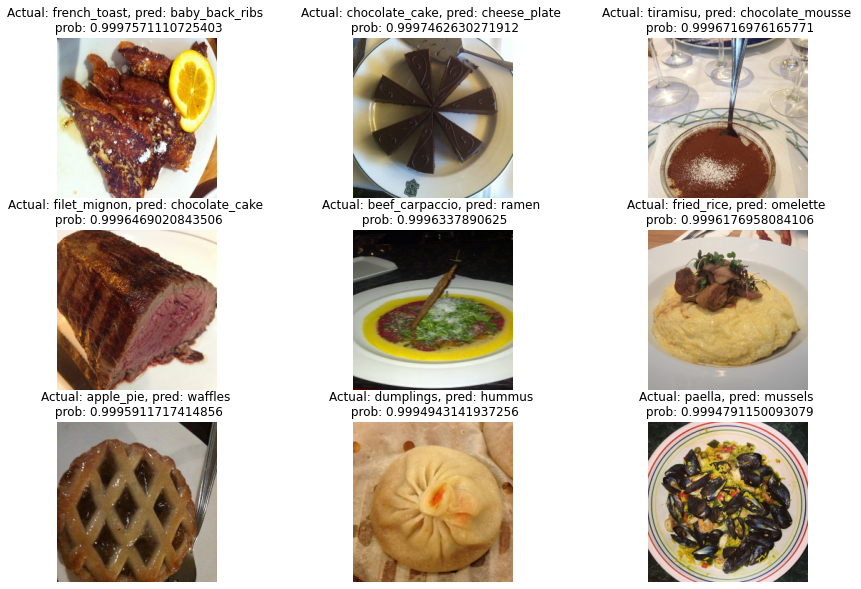

In [ ]:
# 5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

image_to_view = 9
start_index = 20
plt.figure(figsize=[15,10])
for i , row in enumerate(top_100_wrong[start_index:start_index+image_to_view].itertuples()):
    plt.subplot(3,3,i+1)
    img = load_and_prep_image(row[1],scale=False)
    _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in a few parameters of each row
    plt.imshow(img/255.)
    plt.title(f"Actual: {y_true_classname}, pred: {y_pred_classname} \n prob: {pred_prob}")
    plt.axis(False);


## Test out the big dog model on our own custom images


In [ ]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")


--2022-05-15 13:38:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.128, 142.250.107.128, 173.194.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.1s    

2022-05-15 13:38:20 (89.8 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
# Get the custom image file path
custom_food_image = ["custom_food_images/" + image_path for image_path in os.listdir("custom_food_images")]
custom_food_image

['custom_food_images/hamburger.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/steak.jpeg']

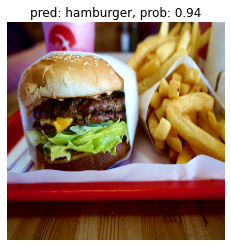

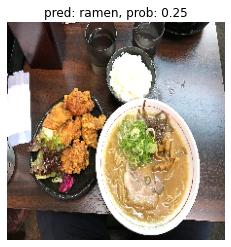

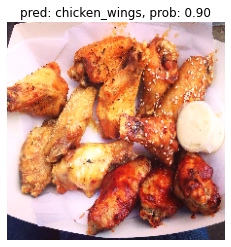

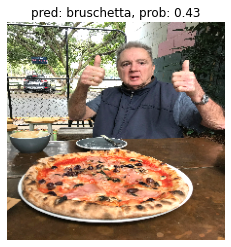

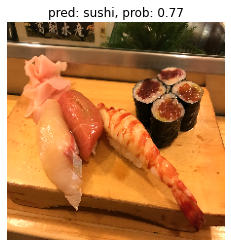

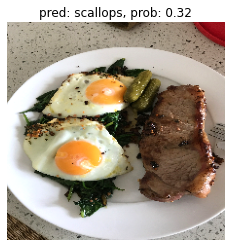

In [ ]:
# Make predictions on and plot custom food images
for img in custom_food_image:
  img = load_and_prep_image(img, scale=False) # don't need to scale for our EfficientNetB0 model
  pred_prob = model_1.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [1, 224, 224, 3] (same shape as model was trained on)
  pred_class = class_names[pred_prob.argmax()] # get the index with the highet prediction probability
  # Plot the appropriate information
  plt.figure()
  plt.imshow(img/225.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)


In [ ]:
my_own_image_uplode = ["/content/drive/MyDrive/101_food_classes_custom_image/" + image_path for image_path in os.listdir("/content/drive/MyDrive/101_food_classes_custom_image")]
my_own_image_uplode

['/content/drive/MyDrive/101_food_classes_custom_image/cannoli.jpg',
 '/content/drive/MyDrive/101_food_classes_custom_image/beef_tarter.jpg',
 '/content/drive/MyDrive/101_food_classes_custom_image/pizza.jpg',
 '/content/drive/MyDrive/101_food_classes_custom_image/Chicken_Curry.jpg']

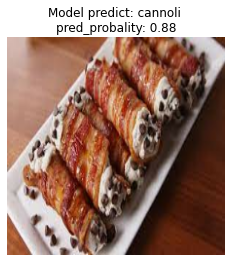

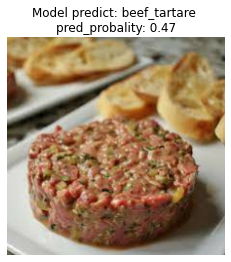

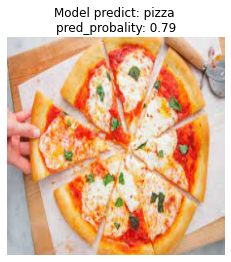

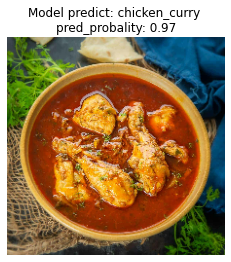

In [ ]:
# my own image upload and check predication
for img in my_own_image_uplode:
    img = load_and_prep_image(img,scale=False)
    pred_prob = model_1.predict(tf.expand_dims(img,axis=0))
    pred_class = class_names[pred_prob.argmax()]
    # plot image 
    plt.figure()
    plt.imshow(img/255.)
    plt.title(f"Model predict: {pred_class} \npred_probality: {pred_prob.max():.2f}")
    plt.axis(False)

## Create Featur extraction model with train 10 epoch

In [ ]:
# setup directory path
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

# Get the data and preprocess 
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMAGE_SIZE,
                                                                 batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                label_mode = "categorical",
                                                                image_size=IMAGE_SIZE,
                                                                batch_size=BATCH_SIZE,
                                                                shuffle=False)



Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
# create the check_point_callback
check_point_path = "Feature_extraction_callback"
model_check_point_callback = tf.keras.callbacks.ModelCheckpoint(filepath=check_point_path,
                                                                monitor="val_accuracy",
                                                                save_weights_only=True,
                                                                save_best_only=True,
                                                                save_freq='epoch')


In [ ]:
# creat base model
input_shape = [224,224,3]
base_model_feature_extraction = tf.keras.applications.EfficientNetB0(include_top=False)
base_model_feature_extraction.trainable = False

# creat input layer
inputs = tf.keras.layers.Input(shape=input_shape,name="inputs_layers")
# pass into base model
x = base_model(inputs,training=False)
# pooled model output
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
# outputs layer create
outputs = tf.keras.layers.Dense(len(test_data.class_names),activation="softmax",name="outputs_layers")(x)
# creat the feature extraction model
model_feature_extraction = tf.keras.Model(inputs,outputs)
# compile the model
model_feature_extraction.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                                 optimizer=tf.keras.optimizers.Adam(),
                                 metrics=["accuracy"])


In [ ]:
# fit the model with Model check point
feature_extraction_history = model_feature_extraction.fit(train_data,
                                                          epochs=10,
                                                          validation_data=test_data,
                                                          validation_steps=int(0.15 * len(test_data)),
                                                          callbacks=[model_check_point_callback])

Epoch 1/10
237/237 [==============================] - 33s 115ms/step - loss: 2.4532 - accuracy: 0.4114 - val_loss: 1.7963 - val_accuracy: 0.5302
Epoch 2/10
237/237 [==============================] - 26s 106ms/step - loss: 1.1783 - accuracy: 0.6842 - val_loss: 1.8145 - val_accuracy: 0.5246
Epoch 3/10
237/237 [==============================] - 26s 107ms/step - loss: 0.7007 - accuracy: 0.8141 - val_loss: 1.8958 - val_accuracy: 0.5360
Epoch 4/10
237/237 [==============================] - 26s 108ms/step - loss: 0.3839 - accuracy: 0.9030 - val_loss: 1.9079 - val_accuracy: 0.5442
Epoch 5/10
237/237 [==============================] - 26s 107ms/step - loss: 0.1986 - accuracy: 0.9547 - val_loss: 2.0282 - val_accuracy: 0.5551
Epoch 6/10
237/237 [==============================] - 26s 107ms/step - loss: 0.1271 - accuracy: 0.9739 - val_loss: 2.1220 - val_accuracy: 0.5392
Epoch 7/10
237/237 [==============================] - 26s 107ms/step - loss: 0.0905 - accuracy: 0.9847 - val_loss: 2.2451 - val_ac

## Evalutate feature extraction model


In [ ]:
model_feature_extraction.evaluate(test_data)

790/790 [==============================] - 56s 71ms/step - loss: 2.0883 - accuracy: 0.5918


[2.088303565979004, 0.591762363910675]

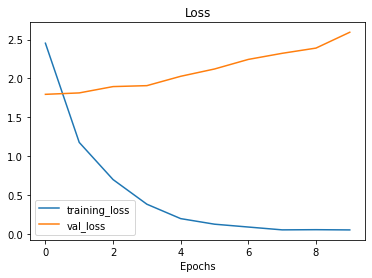

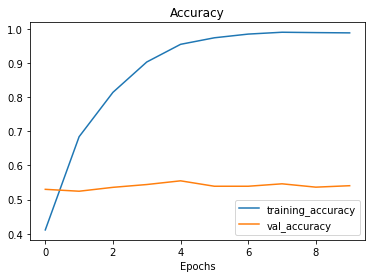

In [ ]:
# see plot loss curves
plot_loss_curves(feature_extraction_history)

In [ ]:
# create fine tunning model
model_feature_extraction.layers[1].trainable = True
# frozen all layer only last 20 layer not frozen
for layer in model_feature_extraction.layers[1].layers[:-30]:
    layer.trainable = False

# recompile the model feature extraction
model_feature_extraction.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])



In [ ]:
print(len(model_feature_extraction.layers[1].trainable_variables))

28


In [ ]:
# check to see how many layer in model_2
for layer_num, layer in enumerate(model_feature_extraction.layers):
    print(f" {layer_num} {layer.name}, {layer.trainable}")

 0 inputs_layers, True
 1 efficientnetb0, True
 2 global_average_pooling_2D, True
 3 outputs_layers, True


In [ ]:
# how many are trainable in base model
for layer_num,layer in enumerate(model_feature_extraction.layers[1].layers):
    print(layer_num,layer.name,layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
# refit the model fine tuning 
fine_tune_history = model_feature_extraction.fit(train_data,
                                epochs=15,
                                validation_data=test_data,
                                validation_steps=int(0.15 * len(test_data)),
                                initial_epoch=feature_extraction_history.epoch[-1])

Epoch 10/15
237/237 [==============================] - 34s 120ms/step - loss: 0.0203 - accuracy: 0.9963 - val_loss: 2.6332 - val_accuracy: 0.5651
Epoch 11/15
237/237 [==============================] - 27s 114ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 2.9018 - val_accuracy: 0.5622
Epoch 12/15
237/237 [==============================] - 28s 116ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 3.0510 - val_accuracy: 0.5630
Epoch 13/15
237/237 [==============================] - 28s 115ms/step - loss: 6.2042e-04 - accuracy: 1.0000 - val_loss: 3.1759 - val_accuracy: 0.5638
Epoch 14/15
237/237 [==============================] - 28s 115ms/step - loss: 4.2585e-04 - accuracy: 1.0000 - val_loss: 3.2872 - val_accuracy: 0.5646
Epoch 15/15
237/237 [==============================] - 28s 115ms/step - loss: 3.1056e-04 - accuracy: 1.0000 - val_loss: 3.3927 - val_accuracy: 0.5636


In [ ]:
# evaluate model
model_feature_extraction.evaluate(test_data)

790/790 [==============================] - 56s 71ms/step - loss: 2.7952 - accuracy: 0.6181


[2.7952444553375244, 0.6181386113166809]

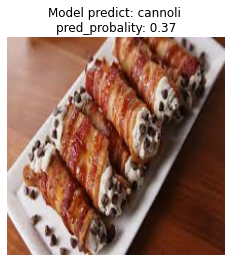

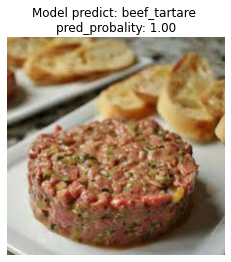

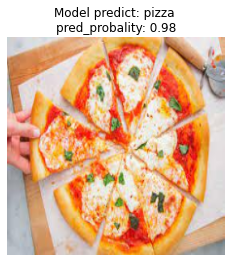

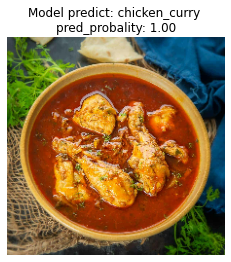

In [ ]:
### custom image predict
# my own image upload and check predication
for img in my_own_image_uplode:
    img = load_and_prep_image(img,scale=False)
    pred_prob = model_feature_extraction.predict(tf.expand_dims(img,axis=0))
    pred_class = class_names[pred_prob.argmax()]
    # plot image 
    plt.figure()
    plt.imshow(img/255.)
    plt.title(f"Model predict: {pred_class} \npred_probality: {pred_prob.max():.2f}")
    plt.axis(False)

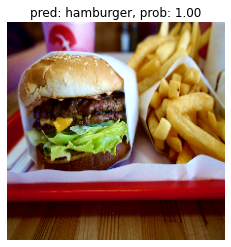

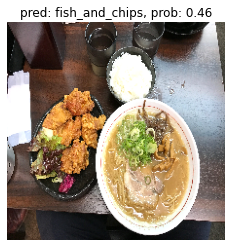

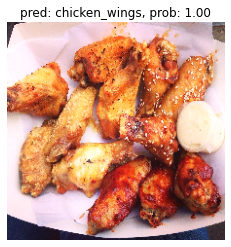

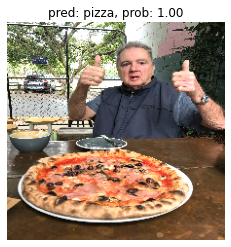

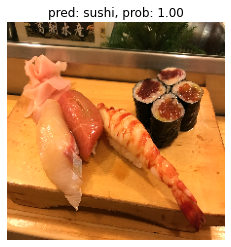

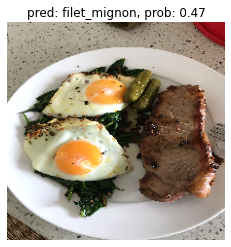

In [ ]:
# Make predictions on and plot custom food images this predication use on ztm provider 
for img in custom_food_image:
  img = load_and_prep_image(img, scale=False) # don't need to scale for our EfficientNetB0 model
  pred_prob = model_feature_extraction.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [1, 224, 224, 3] (same shape as model was trained on)
  pred_class = class_names[pred_prob.argmax()] # get the index with the highet prediction probability
  # Plot the appropriate information
  plt.figure()
  plt.imshow(img/225.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)
